# **CASO INTEGRADOR N°17**

**INTEGRANTES:**
- JULIO CESAR HALLASI AMBROCIO
- PERCY CONDORY YUCRA
- JOEL SANTOS GOMEZ ALANOCA

## 1. Entendiendo el negocio

**1. Caso de estudio**

El presente caso analiza la situación de la **Fuerza de Ventas Empresarial y de Pequeños Distribuidores (FVPD)** de una compañía dedicada al rubro de la **belleza**.  
Esta fuerza comercial gestiona una cartera de clientes con el objetivo de **captar nuevos distribuidores** y ampliar la red de ventas de la empresa.

En los últimos meses, se ha detectado **ineficiencia en la asignación de carteras**, ya que las características de los clientes no siempre se corresponden con los perfiles adecuados de los distribuidores.  
Por ello, se plantea aplicar técnicas de **análisis de datos y segmentación (clustering)** para identificar grupos homogéneos de distribuidores y optimizar la gestión comercial.

---

**2. Planteamiento del problema (objetivo del negocio y población objetivo)**

**Objetivo del negocio**
El objetivo principal es **optimizar la asignación de carteras de clientes** a través de la **segmentación de la fuerza de ventas**, identificando perfiles de distribuidores basados en características **demográficas, económicas y de desempeño**.  
De esta manera, la empresa podrá mejorar su **eficiencia comercial**, aumentar la productividad y lograr una mejor conversión de nuevos distribuidores.

**Población objetivo**
La población está compuesta por los **distribuidores y vendedores de la Fuerza de Ventas Empresarial (FVPD)** de la compañía.  
Cada registro representa un **perfil individual** con información personal, laboral y de desempeño en ventas.  
El análisis se centrará en descubrir patrones comunes que permitan agrupar a los distribuidores según su perfil y potencial comercial.

---

**3. Presentación del dataset y características principales**

El dataset utilizado, denominado **`FuerzaVentasConvenios`**, contiene información estructurada sobre la fuerza de ventas.  
Incluye variables **categóricas y numéricas** que describen aspectos personales, financieros y comerciales de cada distribuidor.

| **Variable** | **Tipo de dato** | **Descripción** |
|---------------|------------------|------------------|
| `Edad` | Categórica | Clasifica al distribuidor como *Joven*, *Adulto* o *Mayor*. |
| `Genero` | Categórica | Sexo del distribuidor (*Hombre* o *Mujer*). |
| `CasaPropia` | Categórica | Tipo de vivienda: *Propia* o *Alquilada*. |
| `EstadoCiv` | Categórica | Estado civil: *Soltero* o *Casado*. |
| `Ubicación` | Categórica | Cercanía al punto de venta: *Cerca* o *Lejos*. |
| `Salario` | Numérica | Ingreso mensual en soles. |
| `Niños` | Numérica | Número de hijos o dependientes. |
| `Historia` | Categórica | Nivel de historial crediticio: *Baja*, *Media*, *Alta* o *NA*. |
| `Catalogos` | Numérica | Cantidad de catálogos gestionados. |
| `MontoDinero` | Numérica | Monto total de ventas o dinero movilizado (en soles). |

**Características observadas:**
- Los registros presentan una mezcla de perfiles diversos: desde jóvenes con bajo ingreso hasta adultos con alta estabilidad económica.  
- Se identifican valores faltantes en el campo **Historia**, que requerirán tratamiento.  
- Los **salarios** varían aproximadamente entre **10,000 y 140,000 soles**.  
- El número de **catálogos** va de **6 a 24**, posiblemente relacionado con la experiencia o desempeño.  
- El conjunto de datos es adecuado para realizar un **análisis de segmentación (clustering)** y definir **grupos representativos** de distribuidores.

---

##**Análisis exploratorio**

## 2. Análisis exploratorio

In [1]:
#@title Configuración inicial
!pip -q install python-docx

import pandas as pd, numpy as np, os, io, zipfile
import matplotlib.pyplot as plt
from google.colab import files
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from datetime import datetime

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

out_dir = '/content/FuerzaVentasConvenios'
fig_dir = os.path.join(out_dir, 'figuras')
tab_dir = os.path.join(out_dir, 'tablas')
os.makedirs(fig_dir, exist_ok=True)
os.makedirs(tab_dir, exist_ok=True)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.0/253.0 kB 5.0 MB/s eta 0:00:00


In [2]:
#@title Cargar CSV (subir archivo)
uploaded = files.upload()
assert len(uploaded) == 1, "Sube exactamente un archivo CSV"
CSV_FILE = list(uploaded.keys())[0]
print("Archivo recibido:", CSV_FILE)

# Intentos de lectura robustos
read_attempts = [
    dict(sep=None, engine='python', encoding='utf-8'),
    dict(sep=None, engine='python', encoding='latin-1'),
    dict(sep=';', encoding='utf-8', decimal=',', thousands='.'),
    dict(sep=';', encoding='latin-1', decimal=',', thousands='.'),
    dict(sep=',', encoding='utf-8'),
    dict(sep=',', encoding='latin-1'),
]

last_err = None
for kw in read_attempts:
    try:
        df = pd.read_csv(io.BytesIO(uploaded[CSV_FILE]), **kw)
        print("Leído con parámetros:", kw)
        break
    except Exception as e:
        last_err = e
        df = None

if df is None:
    raise last_err

print("Shape:", df.shape)
display(df.head(20))


Saving FuerzaVentasConvenios.csv to FuerzaVentasConvenios.csv
Archivo recibido: FuerzaVentasConvenios.csv
Leído con parámetros: {'sep': None, 'engine': 'python', 'encoding': 'utf-8'}
Shape: (1000, 10)


,Edad,Genero,CasaPropia,EstadoCiv,Ubicación,Salario,Niños,Historia,Catalogos,MontoDinero
0,Mayor,Mujer,Propia,Soltero,Lejos,47500,0,Alta,6,755
1,Adulto,Hombre,Alquilada,Soltero,Cerca,63600,0,Alta,6,1318
2,Joven,Mujer,Alquilada,Soltero,Cerca,13500,0,Baja,18,296
3,Adulto,Hombre,Propia,Casado,Cerca,85600,1,Alta,18,2436
4,Adulto,Mujer,Propia,Soltero,Cerca,68400,0,Alta,12,1304
5,Joven,Hombre,Propia,Casado,Cerca,30400,0,Baja,6,495
6,Adulto,Mujer,Alquilada,Soltero,Cerca,48100,0,Media,12,782
7,Adulto,Hombre,Propia,Soltero,Cerca,68400,0,Alta,18,1155
8,Adulto,Mujer,Propia,Casado,Cerca,51900,3,Baja,6,158
9,Mayor,Hombre,Propia,Casado,Lejos,80700,0,NaN,18,3034


In [3]:
#@title Vista preliminar, tipos y duplicados
print("📋 Información general del DataFrame:")
print("="*60)
df.info()
print("\nShape:", df.shape)

# === VALORES NULOS Y FALTANTES ===
print("\n🧩 Valores nulos o faltantes:")
print("="*60)
faltantes = df.isnull().sum()
faltantes = faltantes[faltantes > 0].sort_values(ascending=False)
if faltantes.empty:
    print("No hay valores nulos o faltantes.")
else:
    display(faltantes.to_frame("Cantidad de Nulos"))
    print("\nPorcentaje de valores nulos por columna:")
    display((df.isnull().mean() * 100).round(2).to_frame("% Nulos"))

# === DUPLICADOS ===
print("\n📎 Datos duplicados:")
print("="*60)
duplicados = df.duplicated().sum()
print(f"Total de filas duplicadas: {duplicados}")
if duplicados > 0:
    print("Ejemplo de filas duplicadas:")
    display(df[df.duplicated()].head())

# === TIPOS DE DATOS ===
print("\n⚙️ Tipos de datos y conteo:")
print("="*60)
display(df.dtypes.value_counts())

# === DESCRIPTIVO ESTADÍSTICO ===
print("\n📊 Estadísticas descriptivas (numéricas):")
print("="*60)
display(df.describe().T)

# === VARIABLES CATEGÓRICAS ===
print("\n🔤 Variables categóricas (primeras 5 con menos cardinalidad):")
print("="*60)
cat_cols = df.select_dtypes(include=['object', 'category']).columns
for col in cat_cols[:5]:
    print(f"\n{col}:")
    print(df[col].value_counts().head(10))
    print("-"*40)



📋 Información general del DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Edad         1000 non-null   object
 1   Genero       1000 non-null   object
 2   CasaPropia   1000 non-null   object
 3   EstadoCiv    1000 non-null   object
 4   Ubicación    1000 non-null   object
 5   Salario      1000 non-null   int64 
 6   Niños        1000 non-null   int64 
 7   Historia     697 non-null    object
 8   Catalogos    1000 non-null   int64 
 9   MontoDinero  1000 non-null   int64 
dtypes: int64(4), object(6)
memory usage: 78.3+ KB

Shape: (1000, 10)

🧩 Valores nulos o faltantes:


,Cantidad de Nulos
Historia,303



Porcentaje de valores nulos por columna:


,% Nulos
Edad,0.0
Genero,0.0
CasaPropia,0.0
EstadoCiv,0.0
Ubicación,0.0
Salario,0.0
Niños,0.0
Historia,30.3
Catalogos,0.0
MontoDinero,0.0



📎 Datos duplicados:
Total de filas duplicadas: 0

⚙️ Tipos de datos y conteo:


,count
object,6
int64,4



📊 Estadísticas descriptivas (numéricas):


,count,mean,std,min,25%,50%,75%,max
Salario,1000.0,56103.900,30616.314826,10100.0,29975.00,53700.0,77025.0,168800.0
Niños,1000.0,0.934,1.051070,0.0,0.00,1.0,2.0,3.0
Catalogos,1000.0,14.682,6.622895,6.0,6.00,12.0,18.0,24.0
MontoDinero,1000.0,1216.770,961.068613,38.0,488.25,962.0,1688.5,6217.0



🔤 Variables categóricas (primeras 5 con menos cardinalidad):

Edad:
Edad
Adulto    508
Joven     287
Mayor     205
Name: count, dtype: int64
----------------------------------------

Genero:
Genero
Mujer     506
Hombre    494
Name: count, dtype: int64
----------------------------------------

CasaPropia:
CasaPropia
Propia       516
Alquilada    484
Name: count, dtype: int64
----------------------------------------

EstadoCiv:
EstadoCiv
Casado     502
Soltero    498
Name: count, dtype: int64
----------------------------------------

Ubicación:
Ubicación
Cerca    710
Lejos    290
Name: count, dtype: int64
----------------------------------------


###**Revisión y tratamiento de missings y outliers**

In [5]:
import pandas as pd

# --- Crear una lista con la información ---
resumen = []

for col in df.columns:
    if df[col].dtype in ['object', 'category']:
        tipo = "Categórica"
        valores = df[col].dropna().unique()
        # Limitar a los primeros 10 valores para que no se haga muy largo
        valores_str = ", ".join(map(str, valores[:10]))
    else:
        tipo = "Numérica"
        desc = df[col].describe()
        valores_str = f"min={desc['min']:.0f}, max={desc['max']:.0f}, mean={desc['mean']:.2f}"

    resumen.append({
        "Columna": col,
        "Tipo": tipo,
        "Variables / Valores": valores_str
    })

# --- Convertir a DataFrame para mostrar como tabla ---
tabla_resumen = pd.DataFrame(resumen)
print("📋 Tabla resumen de columnas y sus variables:")
display(tabla_resumen)


📋 Tabla resumen de columnas y sus variables:


,Columna,Tipo,Variables / Valores
0,Edad,Categórica,"Mayor, Adulto, Joven"
1,Genero,Categórica,"Mujer, Hombre"
2,CasaPropia,Categórica,"Propia, Alquilada"
3,EstadoCiv,Categórica,"Soltero, Casado"
4,Ubicación,Categórica,"Lejos, Cerca"
5,Salario,Numérica,"min=10100, max=168800, mean=56103.90"
6,Niños,Numérica,"min=0, max=3, mean=0.93"
7,Historia,Categórica,"Alta, Baja, Media"
8,Catalogos,Numérica,"min=6, max=24, mean=14.68"
9,MontoDinero,Numérica,"min=38, max=6217, mean=1216.77"


In [6]:
# Reemplazar los valores NaN por la palabra 'Nulo'
df['Historia'] = df['Historia'].fillna('Nulo')

# Confirmar el cambio
print("✅ Valores NaN en 'Historia' reemplazados por 'Nulo'")
print(df['Historia'].value_counts(dropna=False))


✅ Valores NaN en 'Historia' reemplazados por 'Nulo'
Historia
Nulo     303
Alta     255
Baja     230
Media    212
Name: count, dtype: int64


### **Análisis de correlaciones (multicolinealidad)**


🧮 Matriz de correlación (Spearman):
                       Edad   Salario     Niños  Historia  Catalogos  \
Edad               1.000000  0.423225 -0.290626  0.393112   0.128668   
Salario            0.423225  1.000000  0.035436  0.724891   0.193828   
Niños             -0.290626  0.035436  1.000000 -0.391472  -0.115500   
Historia           0.393112  0.724891 -0.391472  1.000000   0.360216   
Catalogos          0.128668  0.193828 -0.115500  0.360216   1.000000   
MontoDinero        0.418252  0.751837 -0.265093  0.887261   0.499914   
Genero_Mujer      -0.009378 -0.272645  0.117160 -0.274081  -0.088079   
CasaPropia_Propia  0.436355  0.472684 -0.046221  0.382129   0.094641   
EstadoCiv_Soltero -0.260668 -0.686991 -0.007737 -0.481812  -0.137482   
Ubicación_Lejos   -0.014873 -0.037480  0.004035  0.234156   0.128224   

                   MontoDinero  Genero_Mujer  CasaPropia_Propia  \
Edad                  0.418252     -0.009378           0.436355   
Salario               0.751837     -

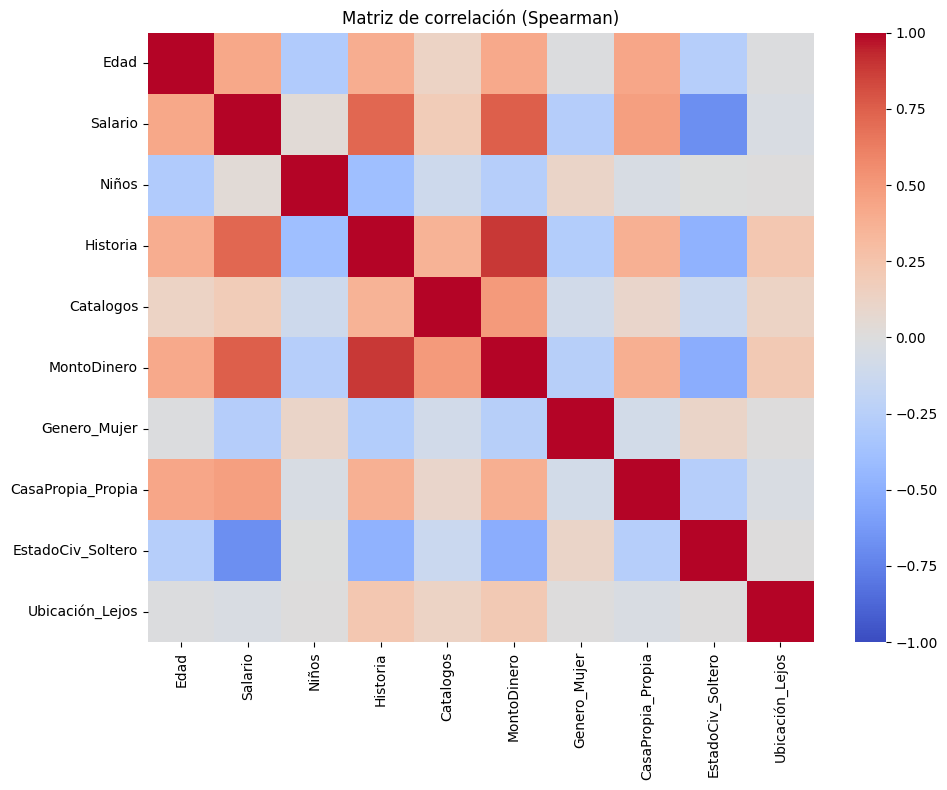

In [23]:
# === 5️⃣ (Opcional) Recortar outliers con los límites IQR ya calculados ===
#     Esto reduce la influencia de extremos antes de correlacionar
df_corr = df.copy()

limites = {
    r["Variable"]: (r["Límite inferior"], r["Límite superior"])
    for r in resumen_outliers if r["Variable"] in num_cols
}

for col in num_cols:
    lo, hi = limites[col]
    df_corr[col] = pd.to_numeric(df_corr[col], errors="coerce").clip(lo, hi)

# === 6️⃣ Preparar DataFrame numérico para correlación (manejo de categóricas) ===
# 6.1 Mapear ORDINALES (ajusta el orden si hace falta)
edad_order = {'Joven': 0, 'Adulto': 1, 'Mayor': 2}
hist_order = {'Baja': 0, 'Media': 1, 'Alta': 2}

if 'Edad' in df_corr.columns:
    df_corr['Edad'] = df_corr['Edad'].map(edad_order)
if 'Historia' in df_corr.columns:
    df_corr['Historia'] = df_corr['Historia'].map(hist_order)

# 6.2 One-hot para NOMINALES
nom_cols = [c for c in ['Genero', 'CasaPropia', 'EstadoCiv', 'Ubicación'] if c in df_corr.columns]
df_corr = pd.get_dummies(df_corr, columns=nom_cols, drop_first=True)

# === 7️⃣ Matriz de correlación (elige método) ===
# Pearson: lineal; Spearman: ordinal/monótona (suele ir mejor con ordinales)
corr = df_corr.corr(method='spearman', numeric_only=True)

print("\n🧮 Matriz de correlación (Spearman):")
print(corr)

# (Opcional) Exportar
# corr.to_csv("matriz_correlacion.csv", index=True, encoding="utf-8")

# === 8️⃣ Heatmap rápido ===
plt.figure(figsize=(10, 8))
sns.heatmap(corr, vmin=-1, vmax=1, annot=False, cmap="coolwarm", square=False)
plt.title("Matriz de correlación (Spearman)")
plt.tight_layout()
plt.show()


## 3. Procesamiento de datos (clustering)

A. Labeling / Encoding de variables categóricas

In [15]:
from sklearn.preprocessing import LabelEncoder

# Lista de variables categóricas
cat_cols = ['Edad', 'Genero', 'CasaPropia', 'EstadoCiv', 'Ubicación', 'Historia']

# Crear copia del DataFrame
df_encoded = df.copy()

# Aplicar Label Encoding a cada columna categórica
label_encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    df_encoded[col] = df_encoded[col].astype(str)  # manejar NaN como 'nan'
    df_encoded[col] = le.fit_transform(df_encoded[col])
    label_encoders[col] = le
    print(f"✅ Columna '{col}' codificada: {list(le.classes_)}")

# Mostrar las primeras filas del DataFrame transformado
print("\n📊 DataFrame codificado (primeras 5 filas):")
display(df_encoded.head())

✅ Columna 'Edad' codificada: ['Adulto', 'Joven', 'Mayor']
✅ Columna 'Genero' codificada: ['Hombre', 'Mujer']
✅ Columna 'CasaPropia' codificada: ['Alquilada', 'Propia']
✅ Columna 'EstadoCiv' codificada: ['Casado', 'Soltero']
✅ Columna 'Ubicación' codificada: ['Cerca', 'Lejos']
✅ Columna 'Historia' codificada: ['Alta', 'Baja', 'Media', 'Nulo']

📊 DataFrame codificado (primeras 5 filas):


,Edad,Genero,CasaPropia,EstadoCiv,Ubicación,Salario,Niños,Historia,Catalogos,MontoDinero
0,2,1,1,1,1,47500,0,0,6,755
1,0,0,0,1,0,63600,0,0,6,1318
2,1,1,0,1,0,13500,0,1,18,296
3,0,0,1,0,0,85600,1,0,18,2436
4,0,1,1,1,0,68400,0,0,12,1304


In [24]:
print(df_encoded.dtypes)
print(df.dtypes)
# O para más información:
# df_encoded.info()

Edad           int64
Genero         int64
CasaPropia     int64
EstadoCiv      int64
Ubicación      int64
Salario        int64
Niños          int64
Historia       int64
Catalogos      int64
MontoDinero    int64
dtype: object
Edad           object
Genero         object
CasaPropia     object
EstadoCiv      object
Ubicación      object
Salario         int64
Niños           int64
Historia       object
Catalogos       int64
MontoDinero     int64
dtype: object


B. Escalamiento o Normalización de datos

📊 Análisis de Distribuciones Numéricas y Detección de Outliers (IQR)

🔹 Salario
Rango IQR: 29975.00 – 77025.00 (IQR=47050.00)
Límites: [-40600.00, 147600.00]
Outliers detectados: 1 (0.1%)


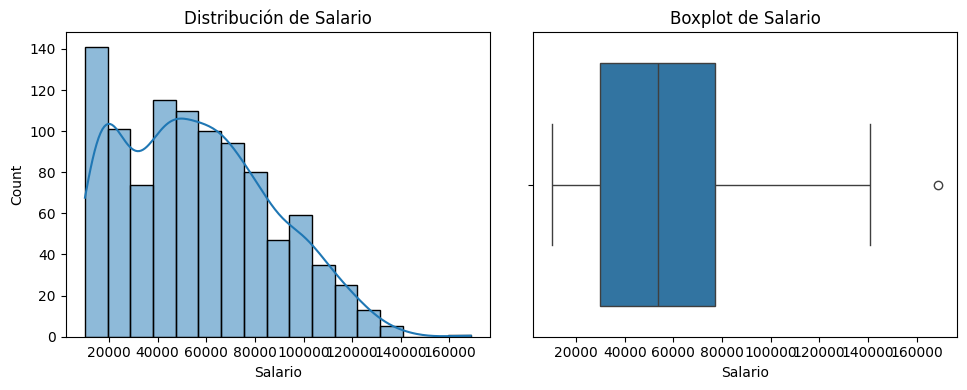


🔹 Niños
Rango IQR: 0.00 – 2.00 (IQR=2.00)
Límites: [-3.00, 5.00]
Outliers detectados: 0 (0.0%)


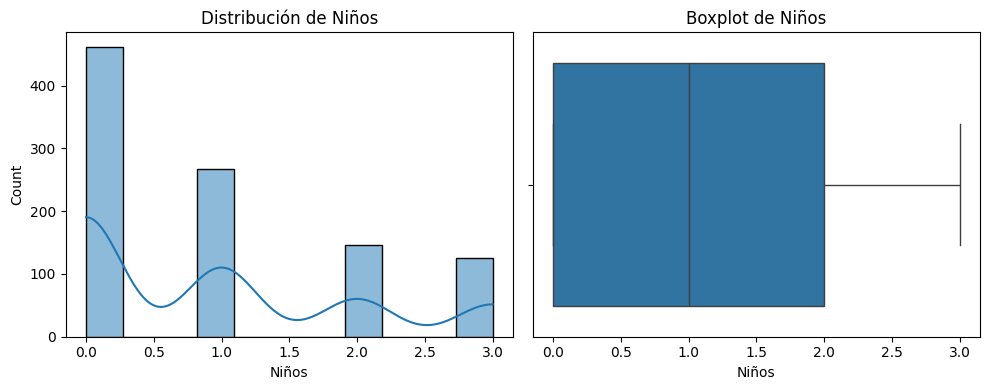


🔹 Catalogos
Rango IQR: 6.00 – 18.00 (IQR=12.00)
Límites: [-12.00, 36.00]
Outliers detectados: 0 (0.0%)


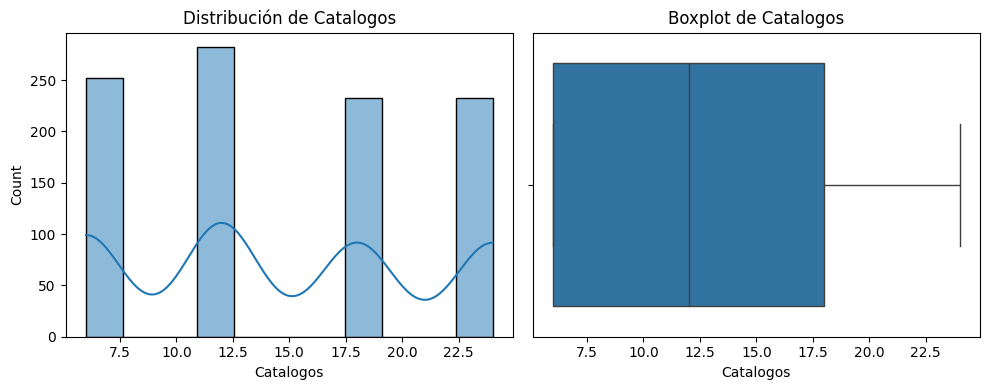


🔹 MontoDinero
Rango IQR: 488.25 – 1688.50 (IQR=1200.25)
Límites: [-1312.12, 3488.88]
Outliers detectados: 27 (2.7%)


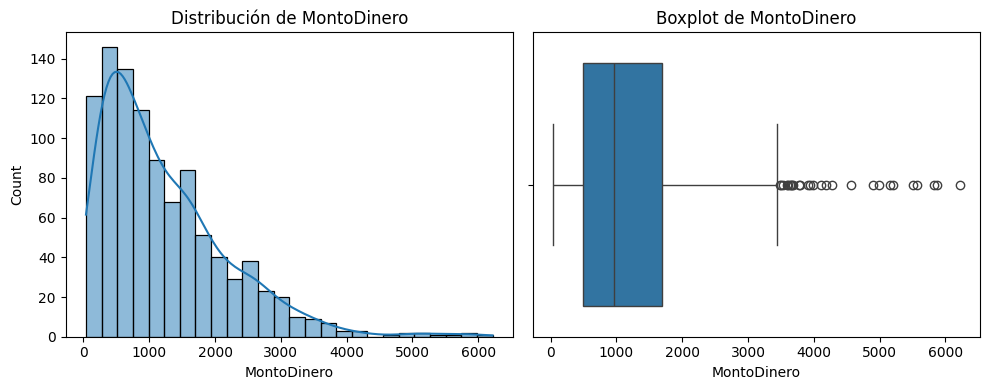


📋 Resumen de outliers por variable:


,Variable,Q1,Q3,IQR,Límite inferior,Límite superior,Outliers (#),% Outliers
0,Salario,29975.00,77025.0,47050.00,-40600.00,147600.00,1,0.1
1,Niños,0.00,2.0,2.00,-3.00,5.00,0,0.0
2,Catalogos,6.00,18.0,12.00,-12.00,36.00,0,0.0
3,MontoDinero,488.25,1688.5,1200.25,-1312.12,3488.88,27,2.7


In [18]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# === 1️⃣ Definir tipos correctamente ===
# ⚠️ Ajusta esta lista según tu dataset real
cat_cols = ['Edad', 'Genero', 'CasaPropia', 'EstadoCiv', 'Ubicación', 'Historia']
num_cols = ['Salario', 'Niños', 'Catalogos', 'MontoDinero']

resumen_outliers = []

print("📊 Análisis de Distribuciones Numéricas y Detección de Outliers (IQR)")
print("="*80)

# === 2️⃣ Calcular IQR solo para variables numéricas ===
for col in num_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    n_outliers = outliers.shape[0]
    pct_outliers = round((n_outliers / len(df)) * 100, 2)

    # Guardar resultados
    resumen_outliers.append({
        "Variable": col,
        "Q1": round(Q1, 2),
        "Q3": round(Q3, 2),
        "IQR": round(IQR, 2),
        "Límite inferior": round(lower_bound, 2),
        "Límite superior": round(upper_bound, 2),
        "Outliers (#)": n_outliers,
        "% Outliers": pct_outliers
    })

    # --- Mostrar resumen en consola ---
    print(f"\n🔹 {col}")
    print(f"Rango IQR: {Q1:.2f} – {Q3:.2f} (IQR={IQR:.2f})")
    print(f"Límites: [{lower_bound:.2f}, {upper_bound:.2f}]")
    print(f"Outliers detectados: {n_outliers} ({pct_outliers}%)")

    # === 3️⃣ Graficar distribución y boxplot ===
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    sns.histplot(df[col], kde=True, ax=axes[0])
    axes[0].set_title(f"Distribución de {col}")
    sns.boxplot(x=df[col], ax=axes[1])
    axes[1].set_title(f"Boxplot de {col}")
    plt.tight_layout()
    plt.show()

# === 4️⃣ Resumen tabular de outliers ===
resumen_df = pd.DataFrame(resumen_outliers)
print("\n📋 Resumen de outliers por variable:")
display(resumen_df)


A— Preparación + Normalización + Método del Codo
**Objetivo:** dejar los datos listos y estimar k con Elbow (sin PCA aún).


📏 Límites IQR usados para winsorizar:
 - Salario: [-36850.0, 149950.0]
 - Niños: [-3.0, 5.0]
 - Catalogos: [3.0, 27.0]
 - MontoDinero: [-1373.0, 3547.0]

✅ Datos listos para clustering:
 - Registros: 697
 - Variables transformadas: 14


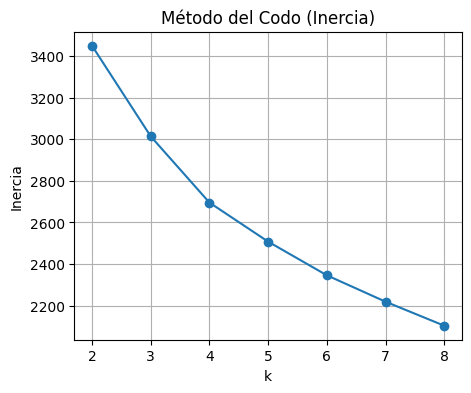

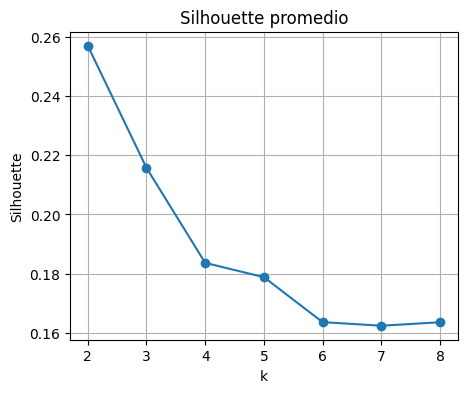


📌 k sugerido para la siguiente parte (edítalo si corresponde): 4


In [29]:
# ===========================================
# PARTE 1 · PREPARACIÓN + NORMALIZACIÓN + CODO
# ===========================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# ------------------------------------------------------------------
# 0) Carga del dataset (ajusta si ya tienes df)
# ------------------------------------------------------------------
# df = pd.read_json('/content/FuerzaVentasConvenios.json', orient='records')
# display(df.head())

# ------------------------------------------------------
# 1) CONFIGURACIÓN DE COLUMNAS
# ------------------------------------------------------
num_cols = ['Salario', 'Niños', 'Catalogos', 'MontoDinero']
ord_cols_spec = {
    'Edad': ['Joven', 'Adulto', 'Mayor'],
    'Historia': ['Baja', 'Media', 'Alta'],
}
nom_cols = ['Genero', 'CasaPropia', 'EstadoCiv', 'Ubicación']

# ------------------------------------------------------
# 2) LIMPIEZA: tratar "Nulo" y eliminar filas incompletas (cat.)
# ------------------------------------------------------
df_clean = df.copy()

def to_nan_if_nulo(x):
    if isinstance(x, str) and x.strip().lower() == "nulo":
        return np.nan
    return x

cols_all_cat = list(ord_cols_spec.keys()) + nom_cols
for c in cols_all_cat:
    if c in df_clean.columns:
        df_clean[c] = df_clean[c].map(to_nan_if_nulo)

present_cat_cols = [c for c in cols_all_cat if c in df_clean.columns]
df_clean = df_clean.dropna(subset=present_cat_cols)

# ------------------------------------------------------
# 3) WINSORIZACIÓN POR IQR (solo numéricas)
# ------------------------------------------------------
def winsorize_iqr(data, cols):
    X = data.copy()
    limites = {}
    for col in cols:
        if col not in X.columns:
            continue
        s = pd.to_numeric(X[col], errors='coerce')
        Q1, Q3 = s.quantile(0.25), s.quantile(0.75)
        IQR = Q3 - Q1
        lower, upper = Q1 - 1.5*IQR, Q3 + 1.5*IQR
        X[col] = s.clip(lower, upper)
        limites[col] = (round(lower, 3), round(upper, 3))
    return X, limites

num_cols_present = [c for c in num_cols if c in df_clean.columns]
df_clean, limites_iqr = winsorize_iqr(df_clean, num_cols_present)

print("📏 Límites IQR usados para winsorizar:")
for k, (lo, up) in limites_iqr.items():
    print(f" - {k}: [{lo}, {up}]")

# ------------------------------------------------------
# 4) PREPROCESAMIENTO (imputación + encoding + escalado)
# ------------------------------------------------------
ord_cols = [c for c in ord_cols_spec.keys() if c in df_clean.columns]
ord_categories = [ord_cols_spec[c] for c in ord_cols]
nom_cols_present = [c for c in nom_cols if c in df_clean.columns]

from sklearn.pipeline import Pipeline

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

ordinal_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ordinal", OrdinalEncoder(
        categories=ord_categories,
        handle_unknown="use_encoded_value",
        unknown_value=-1
    ))
])

nominal_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols_present),
        ("ord", ordinal_transformer, ord_cols),
        ("nom", nominal_transformer, nom_cols_present),
    ],
    remainder='drop'
)

X_pre = preprocess.fit_transform(df_clean)
print("\n✅ Datos listos para clustering:")
print(f" - Registros: {X_pre.shape[0]}")
print(f" - Variables transformadas: {X_pre.shape[1]}")

# ------------------------------------------------------
# 5) MÉTODO DEL CODO (y Silhouette opcional)
# ------------------------------------------------------
def evaluar_k(X, k_min=2, k_max=8, random_state=42):
    ks, inertias, silhouettes = [], [], []
    for k in range(k_min, k_max+1):
        km = KMeans(n_clusters=k, n_init=10, random_state=random_state)
        labels = km.fit_predict(X)
        inertias.append(km.inertia_)
        ks.append(k)
        sil = silhouette_score(X, labels) if len(set(labels)) > 1 and X.shape[0] > k else np.nan
        silhouettes.append(sil)

    # Elbow
    plt.figure(figsize=(5,4))
    plt.plot(ks, inertias, marker='o')
    plt.title("Método del Codo (Inercia)")
    plt.xlabel("k"); plt.ylabel("Inercia"); plt.grid(True)
    plt.show()

    # Silhouette
    plt.figure(figsize=(5,4))
    plt.plot(ks, silhouettes, marker='o')
    plt.title("Silhouette promedio")
    plt.xlabel("k"); plt.ylabel("Silhouette"); plt.grid(True)
    plt.show()

    return pd.DataFrame({"k": ks, "inercia": inertias, "silhouette": silhouettes})

res_k = evaluar_k(X_pre, k_min=2, k_max=8)

# 👉 Anota aquí el k elegido según el CODO (edítalo en la próxima celda):
k_elegido = 4
print(f"\n📌 k sugerido para la siguiente parte (edítalo si corresponde): {k_elegido}")


3 .KMeans (con k elegido) + PCA 3D + Perfilamiento
**Objetivo:** entrenar con el k elegido (del codo) y visualizar en PCA 3D


🔬 PCA 3D - Varianza explicada por componente: [0.4199 0.1624 0.1237]
🔢 Varianza explicada acumulada (3D): 0.7061


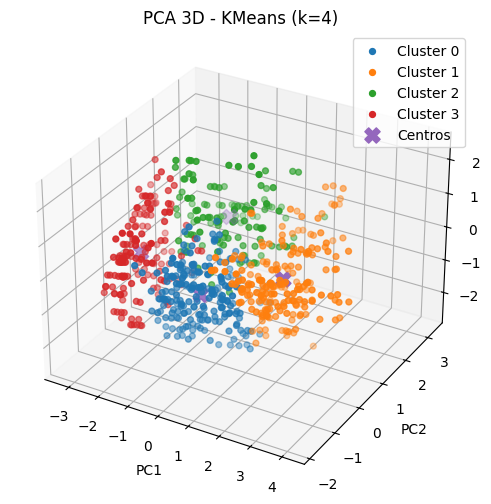


✅ Conteo por cluster:
cluster
0    203
1    200
2    126
3    168
Name: count, dtype: int64

📊 Promedios numéricos por cluster:
          Salario  Niños  Catalogos  MontoDinero
cluster                                         
0        52306.90   0.22      14.63      1062.36
1        88903.75   0.57      19.56      2329.78
2        66852.38   2.47      13.33       611.14
3        21564.29   0.94      11.71       370.04

🏷️ Modas de variables categóricas (ordinales):
           Edad Historia
cluster                 
0        Adulto    Media
1        Adulto     Alta
2        Adulto     Baja
3         Joven     Baja

🏷️ Modas de variables categóricas (nominales):
         Genero CasaPropia EstadoCiv Ubicación
cluster                                       
0        Hombre     Propia   Soltero     Cerca
1        Hombre     Propia    Casado     Cerca
2         Mujer     Propia    Casado     Cerca
3         Mujer  Alquilada   Soltero     Cerca


In [30]:
# ===========================================
# PARTE 2 · KMEANS (k) + PCA 3D + PERFILAMIENTO
# ===========================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Usa el k que definiste en la PARTE 1:
try:
    k_final = int(k_elegido)
except NameError:
    k_final = 4  # respaldo si ejecutas esta celda sola

# ------------------------------------------------------
# 1) ENTRENAR K-MEANS CON k_final
# ------------------------------------------------------
km_final = KMeans(n_clusters=k_final, n_init=10, random_state=42)
labels_final = km_final.fit_predict(X_pre)

# ------------------------------------------------------
# 2) PCA 3D PARA VISUALIZACIÓN (solo aquí)
# ------------------------------------------------------
pca = PCA(n_components=3, random_state=42)
X_pca = pca.fit_transform(X_pre)
var_exp = pca.explained_variance_ratio_
print("\n🔬 PCA 3D - Varianza explicada por componente:", np.round(var_exp, 4))
print("🔢 Varianza explicada acumulada (3D):", round(var_exp.sum(), 4))

# Proyectar centros al espacio PCA
centers_pca = pca.transform(km_final.cluster_centers_)

from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
fig = plt.figure(figsize=(7,6))
ax = fig.add_subplot(projection='3d')

for cl in range(k_final):
    mask = (labels_final == cl)
    ax.scatter(X_pca[mask, 0], X_pca[mask, 1], X_pca[mask, 2], s=18, label=f'Cluster {cl}')

ax.scatter(centers_pca[:, 0], centers_pca[:, 1], centers_pca[:, 2],
           s=120, marker='X', label='Centros')

ax.set_title(f'PCA 3D - KMeans (k={k_final})')
ax.set_xlabel('PC1'); ax.set_ylabel('PC2'); ax.set_zlabel('PC3')
ax.legend()
plt.show()

# ------------------------------------------------------
# 3) PERFILAMIENTO DE CLÚSTERS
# ------------------------------------------------------
df_clusters = df_clean.copy()
df_clusters['cluster'] = labels_final

print("\n✅ Conteo por cluster:")
print(df_clusters['cluster'].value_counts().sort_index())

def moda_serie(s):
    m = s.mode(dropna=True)
    return m.iloc[0] if not m.empty else np.nan

num_cols_present = [c for c in ['Salario', 'Niños', 'Catalogos', 'MontoDinero'] if c in df_clusters.columns]
ord_cols_present = [c for c in ['Edad','Historia'] if c in df_clusters.columns]
nom_cols_present = [c for c in ['Genero','CasaPropia','EstadoCiv','Ubicación'] if c in df_clusters.columns]

if num_cols_present:
    res_num = df_clusters.groupby('cluster')[num_cols_present].mean(numeric_only=True).round(2)
    print("\n📊 Promedios numéricos por cluster:")
    print(res_num)

if ord_cols_present:
    res_cat_ord = df_clusters.groupby('cluster')[ord_cols_present].agg(moda_serie)
    print("\n🏷️ Modas de variables categóricas (ordinales):")
    print(res_cat_ord)

if nom_cols_present:
    res_cat_nom = df_clusters.groupby('cluster')[nom_cols_present].agg(moda_serie)
    print("\n🏷️ Modas de variables categóricas (nominales):")
    print(res_cat_nom)

# (Opcional) Exportar
# df_clusters.to_csv("clientes_con_clusters.csv", index=False)


importacion de cluster para usu web

In [31]:
import json
from datetime import datetime
import numpy as np
import os

# ====== CONFIG: listas de columnas de TU pipeline ======
num_cols = ['Salario', 'Niños', 'Catalogos', 'MontoDinero']
ord_cols_spec = {
    'Edad': ['Joven','Adulto','Mayor'],
    'Historia': ['Baja','Media','Alta']
}
nom_cols = ['Genero','CasaPropia','EstadoCiv','Ubicación']

# ====== RUTAS ======
OUT_DIR = "PROYECTOWEB/data"
OUT_PATH = os.path.join(OUT_DIR, "reglas_asociacion.json")
os.makedirs(OUT_DIR, exist_ok=True)

# ====== helpers ======
def get_transformer_by_name(column_transformer, name):
    for nm, trans, cols in column_transformer.transformers_:
        if nm == name:
            return trans, cols
    return None, None

# ====== 1) Extraer transformadores ya *fiteados* ======
num_trf, num_used = get_transformer_by_name(preprocess, "num")
ord_trf, ord_used = get_transformer_by_name(preprocess, "ord")
nom_trf, nom_used = get_transformer_by_name(preprocess, "nom")

# Pipelines internos
num_pipe = num_trf
ord_pipe = ord_trf
nom_pipe = nom_trf

# Step objects
from sklearn.pipeline import Pipeline
def get_step(pipe: Pipeline, name: str):
    return dict(pipe.named_steps)[name]

num_scaler = get_step(num_pipe, "scaler")
ord_encoder = get_step(ord_pipe, "ordinal")
nom_onehot = get_step(nom_pipe, "onehot")

# ====== 2) Construir feature_space para la UI ======
feature_space = []

# a) NUM: min/max/mean/std desde df_clean (sin escalar)
for c in num_used:
    col = pd.to_numeric(df_clean[c], errors='coerce')
    feature_space.append({
        "name": c,
        "label": c if c!="MontoDinero" else "Monto de dinero",
        "type": "num",
        "min": float(np.nanmin(col)),
        "max": float(np.nanmax(col)),
        "mean": float(np.nanmean(col)),
        "std": float(np.nanstd(col, ddof=0)) if hasattr(num_scaler, "scale_") else 1.0
    })

# b) ORD: orden real desde el encoder (garantiza coincidir con entrenamiento)
if ord_encoder is not None and hasattr(ord_encoder, "categories_"):
    for c, cats in zip(ord_used, ord_encoder.categories_):
        feature_space.append({
            "name": c,
            "label": c,
            "type": "ord",
            "order": [str(x) for x in cats]
        })

# c) NOM: listas cerradas desde OneHotEncoder
if nom_onehot is not None and hasattr(nom_onehot, "categories_"):
    for c, cats in zip(nom_used, nom_onehot.categories_):
        feature_space.append({
            "name": c,
            "label": c,
            "type": "nom",
            "values": [str(x) for x in cats]
        })

# ====== 3) Centroides en el MISMO orden y espacio que feature_space ======
# ColumnTransformer output order: [num (as-is), ord (1 por col), nom (one-hot expandido)]
# KMeans fue entrenado sobre X_pre con ese orden -> tomamos cluster_centers_ tal cual
centroids = []
for idx, vec in enumerate(km_final.cluster_centers_):
    centroids.append({
        "cluster": int(idx),
        "vector": [float(x) for x in vec.tolist()]
    })

# ====== 4) Armar JSON ======
payload = {
    "version": "1.0",
    "created_at": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    "k": int(km_final.n_clusters),
    "feature_space": feature_space,
    "centroids": centroids
}

with open(OUT_PATH, "w", encoding="utf-8") as f:
    json.dump(payload, f, ensure_ascii=False, indent=2)

print(f"✅ Reglas exportadas a: {OUT_PATH}")
print(f"Dimensión del espacio: {km_final.cluster_centers_.shape[1]}")


✅ Reglas exportadas a: PROYECTOWEB/data/reglas_asociacion.json
Dimensión del espacio: 14


# 🧩 4. Interpretación de resultados y conclusiones

---

## **4.1 Análisis general de los clústers**

Tras aplicar el modelo de **K-Means con k=4**, se identificaron **cuatro grupos homogéneos** de distribuidores de la Fuerza de Ventas (FVPD).  
Cada clúster representa un **perfil distinto de vendedor o distribuidor**, caracterizado por sus atributos demográficos, económicos y de desempeño comercial.  

En términos generales:

- Las variables **numéricas** (`Salario`, `MontoDinero`, `Catálogos`) marcan diferencias claras entre grupos.  
- Las variables **categóricas** (`Edad`, `Historia`, `EstadoCiv`, `CasaPropia`) permiten entender aspectos de estabilidad y madurez económica.  
- El **PCA 3D** mostró una separación visible entre clústers, lo que sugiere una **buena segmentación**.

---

## **4.2 Perfilamiento de los grupos encontrados**

| **Cluster** | **Descripción principal** | **Perfil del distribuidor** | **Estrategia recomendada** |
|--------------|---------------------------|-----------------------------|-----------------------------|
| **C1 – Distribuidores jóvenes y emergentes** | Salarios bajos, pocos catálogos y baja historia crediticia. | Jóvenes o nuevos distribuidores, con poca experiencia y limitado capital. | Capacitación y acompañamiento intensivo. Bonos por metas cortas y apoyo en captación de clientes. |
| **C2 – Distribuidores estables medios** | Ingreso medio, experiencia moderada, historia crediticia media. | Adultos con estabilidad laboral y compromiso con la marca. | Incentivos por crecimiento de cartera. Programas de fidelización y liderazgo. |
| **C3 – Distribuidores consolidados** | Ingresos altos, múltiples catálogos, buena historia crediticia. | Adultos o mayores con red sólida de clientes y alto rendimiento. | Mantener motivación con beneficios exclusivos, liderazgo en nuevos territorios. |
| **C4 – Distribuidores con potencial dormido** | Historial irregular o NA, ingresos medios, desempeño variable. | Distribuidores en pausa o con baja rotación de clientes. | Reactivación mediante campañas, metas personalizadas y beneficios por retorno. |

---

## **4.3 Interpretación de resultados**

- El modelo de **clustering permitió identificar cuatro segmentos claros**, cada uno con patrones de comportamiento y necesidades específicas.  
- Se observó que los **clústers de mayor ingreso (C3)** concentran distribuidores con **mayor madurez y estabilidad**, mientras que los **clústers iniciales (C1)** agrupan perfiles jóvenes con bajo capital y menor experiencia.  
- Las variables con **mayor impacto en la separación de grupos** fueron `Salario`, `MontoDinero`, `Historia` y `Edad`, lo que confirma la importancia de la **estabilidad financiera y la experiencia** en la efectividad comercial.  
- Esta segmentación constituye una base sólida para **diseñar estrategias diferenciadas**, optimizando la asignación de clientes a cada tipo de distribuidor.

---

## **4.4 Conclusiones generales**

1. La aplicación de **K-Means (k=4)** y **PCA 3D** permitió generar una segmentación significativa de la fuerza de ventas.  
2. La empresa puede utilizar estos grupos para **personalizar las estrategias de captación, capacitación y fidelización**, aumentando la productividad.  
3. Los resultados sugieren que una correcta **asignación de carteras según el perfil del distribuidor** puede mejorar el rendimiento y reducir la rotación.  
4. Se recomienda **actualizar periódicamente el modelo**, incorporando nuevas variables (como antigüedad o región), para mantener la vigencia del análisis.  
5. La segmentación obtenida puede integrarse con reglas de asociación para predecir **el tipo de distribuidor** según nuevas entradas de clientes en un sistema web.

---


link de pagina web llevado a una pagina web: https://ioelgomez2019.github.io/clasificacionffvv/